### Documentation
This notebook demonstrates how to align and combine ESO 137-002 obtained with both WFC3 and ACS instruments.

* [DrizzlePac Handbook](https://www.stsci.edu)
* [Software Installation Guide](https://astroconda.readthedocs.io/en/latest/)
* [Video Tutorials](https://www.stsci.edu/hst)
* [Drizzlepac Examples](https://www.stsci.edu/scientific-community/software/drizzlepac.html)

### [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)
    The MAST Portal lets you search multiple collections of astronomical datasets 
    all in one place. Use this tool to find astronomical data, publications, and images.
    The below snippet will download the target files.

```python
import ftplib

ftps = ftplib.FTP_TLS('archive.stsci.edu')
ftps.login(user='anonymous', passwd= 'email@uah.edu')
ftps.prot_p() # This is a really good idea :)
ftps.cwd('stage')
stagedir = 'anonymous/anonymous97612'
ftps.cwd(stagedir)

filenames = ftps.nlst()
for filename in filenames:
    print("getting " + filename)
    with open(filename, 'wb') as fp: 
        ftps.retrbinary('RETR {}'.format(filename), fp.write)
 ```

### [Environment Setup](https://astroconda.readthedocs.io/en/latest/)

#### Configure Conda to use the Astroconda Channel

```bash
conda config --add channels http://ssb.stsci.edu/astroconda
conda create -n astroconda python=3.7 stsci
source activate astroconda

#if numpy error persists
conda create -n astroconda python=3.9 readline=8.1.0 ipython jupyter notebook
conda activate astroconda
pip install -U drizzlepac==3.4.1 gwcs photutils tweakwcs spherical-geometry numpy==1.21.5 matplotlib 
```

### 1. Tweakreg: Align HST Mosaics
Use drizzlepac tweakreg to improve image alignment using matched sources between frames within the filter 


### Import software
```python
import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
```

#### F475W filter

Setting up logfile :  del_tweakreg_F475W.log
TweakReg Version 3.4.1 started at: 11:17:20.029 (04/05/2022) 

Version Information
--------------------
Python Version [Clang 12.0.1 ]
3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:27:05) 
numpy Version -> 1.21.5 
astropy Version -> 5.0.4 
stwcs Version -> 1.7.2 

Finding shifts for: 
    /Users/sunil/Documents/Test_SBS1520+503/F475W/jera01hgq_deepCR_flc.fits
    /Users/sunil/Documents/Test_SBS1520+503/F475W/jera01hcq_deepCR_flc.fits

===  Source finding for image '/Users/sunil/Documents/Test_SBS1520+503/F475W/jera01hgq_deepCR_flc.fits':
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F475W/jera01hgq_deepCR_flc.fits', EXT=('SCI', 1) started at: 11:17:20.523 (04/05/2022)
     Found 304 objects.
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F475W/jera01hgq_deepCR_flc.fits', EXT=('SCI', 2) started at: 11:17:21.360 (04/05/2022)
     Found 429 objects.
===  FINAL number of objects in image '/Users/s

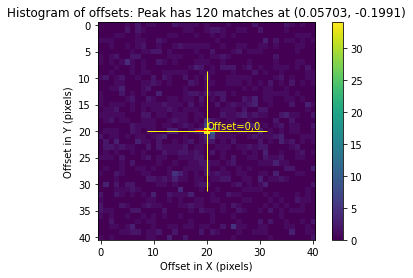

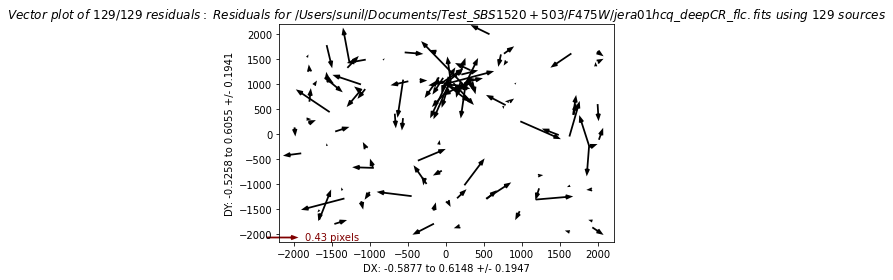

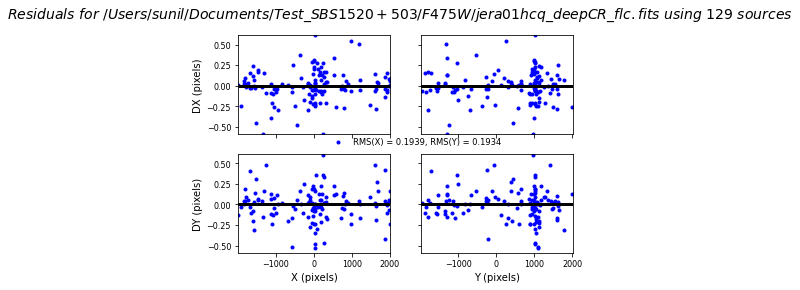

In [4]:
#align a set of ACS *flc.fits frames
tweakreg.TweakReg('F475W/*flc.fits',
                  runfile='tweakreg_F475W.log',
                  imagefindcfg={'threshold': 16.0},
                  #refimage='F475W/jera01hgq_flc.fits',
                  #expand_refcat=True,
                  #enforce_user_order=False,
                  #shiftfile=True,
                  #outshifts='shift475_flc.txt',
                  searchrad=1.0,
                  minobj=50,
                  #use2dhist=False,
                  #xoffset=-0.14,
                  #yoffset=-0.278,
                  updatehdr=False, 
                  reusename=True,
                  wcsname='TWEAK',
                  clean=True,
                  interactive=False)

#### `Important parameters:`

**imagefindcfg**={'threshold': 16.0}, # select 8 if it detects more sources/CRs & 32, 64 if less

**refimage**='F475W/jera01hgq_flc.fits', # if not given, tweakreg automatically selects ref image

**searchrad**=1.0, # adjust it if tweakreg capture less or more sources

**minobj**=50, # same as above

**updatehdr**= False initially, after inspecting the final shifts change to True 

**wcsname**='TWEAK', #should be always TWEAK


### 2. Astrodrizzle: Combine HST frames 
    removes geometric distortion, corrects for sky background variations,
    flags cosmic-rays, and combines images into single mosaic. 
    final_scale is decided upon checking the ratio (arcsec per pix) from DS9
    Note that users must first set the parameter `final_wcs='True'

In [ ]:
astrodrizzle.AstroDrizzle('F475W/*flc.fits',
                          output='F475W-SBS1520+503_test',
                          runfile='astrodrizzle_F475W.log',
                          wcskey='TWEAK',
                          context=False,
                          build=True, 
                          clean=True,
                          final_wht_type='IVM',
                          final_wcs=True,
                          final_rot=0,
                          final_scale=0.03)

### 3. Repeat for  F275W, F814W, etc
- Once F475W filter is done, you can apply tweakreg in same fashion 
- First, align frames within the same filter, no need to choose ref image, don't forget to choose final_wcs = true to save
- Next, repeat tweakreg but now keeping the F475W/jblw01mzq_flc.fits as ref image so that all sources will align not only within the filter but all filters. 
- Whle running astrodrizzle, select final_refimage='F475W-SBS1520+503_drc.fits' to keep same FITS shape (nx, ny) for all filters 
- For 275W, threshold ~16.0 - 32.0 since it will detect too many Crs at low value. 
- X-rms/Y-rms should be $\leq$ 0.2 for ACS and $\leq$ 0.5 for UVIS

#### E.g., F275W filter


Setting up logfile :  tweakreg_F275W.log
TweakReg Version 3.4.1 started at: 10:00:03.769 (15/05/2022) 

Version Information
--------------------
Python Version [Clang 12.0.0 ]
3.9.12 (main, Apr  5 2022, 01:53:17) 
numpy Version -> 1.21.5 
astropy Version -> 5.0.4 
stwcs Version -> 1.7.2 

Finding shifts for: 
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h1q_flc.fits
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_flc.fits

===  Source finding for image '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits':
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits', EXT=('SCI', 1) started at: 10:00:04.237 (15/05/2022)
     Found 7851 objects.
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits', EXT=('SCI', 2) started at: 10:00:06.004 (15/05/2022)
     Found 5386 objects.
===  FINAL number of objects in image '/Use

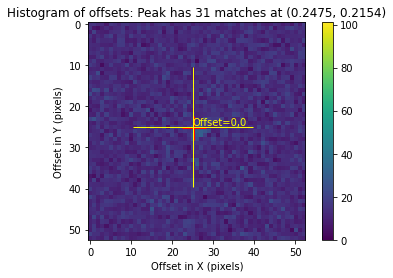

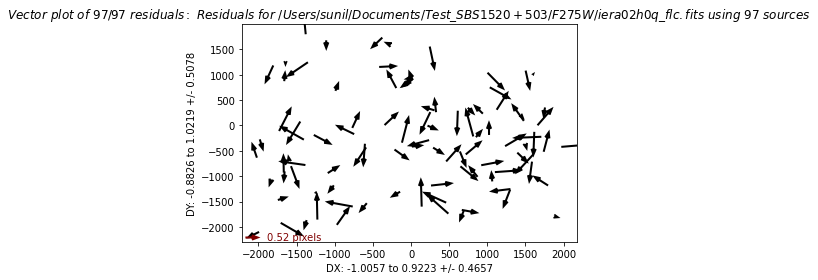

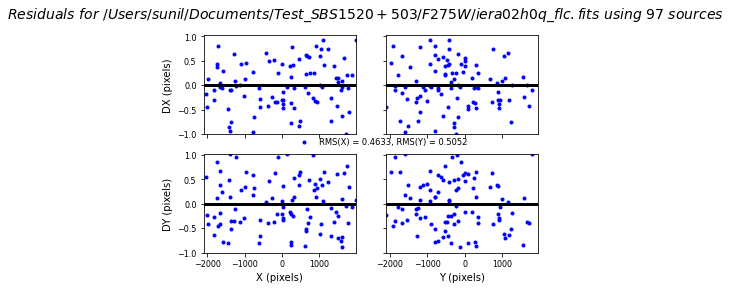

In [3]:
tweakreg.TweakReg('F275W/*flc.fits',
                  runfile='tweakreg_F275W.log',
                  imagefindcfg={'threshold': 512.0, 'conv_width': 3.5, 'dqbits': ~4096},
                  shiftfile=True,
                  outshifts='shift_f275w.txt',
                  searchrad=1.0,
                  minobj=50,
                  #use2dhist=False,
                  #xoffset=-0.4,
                  #yoffset=-0.278,
                  updatehdr=True, 
                  reusename=True,
                  wcsname='TWEAK',
                  clean=True,
                  interactive=False)

#### Align with F475W filter

Setting up logfile :  tweakreg_F275W.log
TweakReg Version 3.4.1 started at: 12:04:35.46 (15/05/2022) 

Version Information
--------------------
Python Version [Clang 12.0.0 ]
3.9.12 (main, Apr  5 2022, 01:53:17) 
numpy Version -> 1.21.5 
astropy Version -> 5.0.4 
stwcs Version -> 1.7.2 

Finding shifts for: 
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h1q_flc.fits
    /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_flc.fits

===  Source finding for image '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits':
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits', EXT=('SCI', 1) started at: 12:04:35.922 (15/05/2022)
     Found 7851 objects.
  #  Source finding for '/Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits', EXT=('SCI', 2) started at: 12:04:37.720 (15/05/2022)
     Found 5386 objects.
===  FINAL number of objects in image '/User


Updating header for /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_flc.fits[1]
WCS Keywords

CD_11  CD_12: 1.0415667997852484e-05 -3.0867982595441322e-06
CD_21  CD_22: -3.7508881850865115e-06 -1.0629902552782882e-05
CRVAL    : 230.5183102185045 50.194472096967594
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plate Scale : 0.0398490047597997
ORIENTAT : -163.80732639790972
WCSNAME  :  TWEAK

Processing /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_flc.fits['SCI',2]

Updating header for /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_flc.fits[4]
WCS Keywords

CD_11  CD_12: 1.0333900030733438e-05 -3.060522793161009e-06
CD_21  CD_22: -3.7958336055288183e-06 -1.0500734777640744e-05
CRVAL    : 230.50830321104442 50.17247944897271
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plate Scale : 0.03962770046218045
ORIENTAT : -163.75081612943575
WCSNAME  :  TWEAK
Writing out shiftfile : shift_f275w.txt
Trailer file written to:  tweakreg_F275W.log


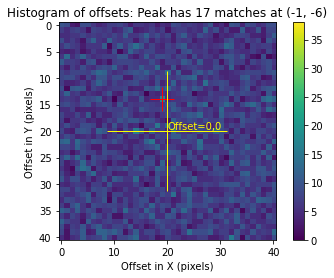

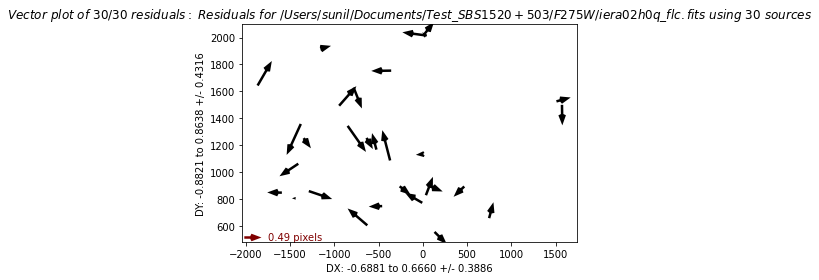

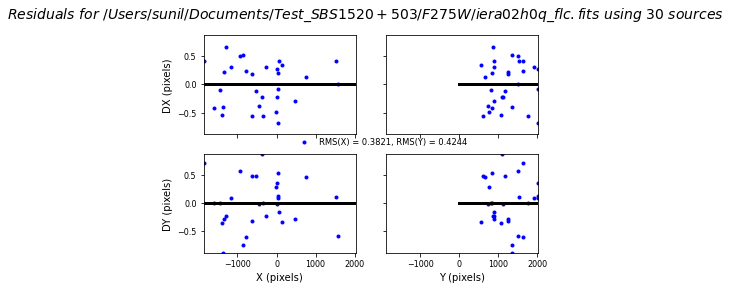

In [33]:
tweakreg.TweakReg('F275W/*flc.fits',
                  runfile='tweakreg_F275W.log',
                  imagefindcfg={'threshold': 512.0, 'conv_width': 3.5, 'dqbits': ~4096},
                  refimage='F475W/jblw01mzq_flc.fits',
                  refimagefindcfg={'threshold': 12.0, 'conv_width': 3.5, 'dqbits': ~4096},
                  shiftfile=True,
                  outshifts='shift_f275w.txt',
                  searchrad=1.0,
                  minobj=7,
                  #use2dhist=False,
                  #xoffset=-0.4,
                  #yoffset=-0.278,
                  updatehdr=True, 
                  reusename=True,
                  wcsname='TWEAK',
                  clean=True,
                  interactive=False)

#### Astrodrizzle

In [34]:
astrodrizzle.AstroDrizzle('F275W/*flc.fits',
                          output='F275W-SBS1520+503_drc',
                          runfile='astrodrizzle_F275W.log',
                          wcskey='TWEAK',
                          context=False,
                          build=True, 
                          clean=True,
                          final_wht_type='IVM',
                          final_wcs=True,
                          final_scale=0.03,
                          #final_rot=0,
                          final_refimage='F475W-SBS1520+503_drc.fits')

Setting up logfile :  astrodrizzle_F275W.log
AstroDrizzle log file: astrodrizzle_F275W.log
AstroDrizzle Version 3.4.1 started at: 12:05:00.589 (15/05/2022)

==== Processing Step  Initialization  started at  12:05:00.592 (15/05/2022)

Creating OUTPUT WCS from F475W/F475W-SBS1520+503_drc.fits[1]
WCS Keywords

CD_11  CD_12: -8.333333333333332e-06 0.0
CD_21  CD_22: 0.0 8.333333333333363e-06
CRVAL    : 230.529945153112 50.17964610961117
CRPIX    : 4604.036580649917 4568.158136805029
NAXIS    : 9209 9134
Plate Scale : 0.03
ORIENTAT : 0.0
********************************************************************************
*
*  Estimated memory usage:  up to 6160 Mb.
*  Output image size:       9209 X 9134 pixels. 
*  Output image file:       ~ 962 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 12:05:04.126 (15/05/2022)
==== Processing Step  Static Mask  started at  12:05:04.130 (

Writing out image to disk: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_sci1_blt.fits
    Blot: creating blotted image:  /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_sci2_blt.fits
Writing out image to disk: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_sci2_blt.fits
==== Processing Step Blot finished at 12:05:45.127 (15/05/2022)
==== Processing Step  Driz_CR  started at  12:05:45.129 (15/05/2022)

Creating output: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_sci1_crmask.fits
Creating output: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h1q_sci1_crmask.fits
Creating output: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h2q_sci1_crmask.fits
Creating output: /Users/sunil/Documents/Test_SBS1520+503/F275W/iera02h0q_sci2_crmask.fits
Creating output: /Users/sunil/Documents/Test_SBS1520